In [126]:
import os
import time, datetime
import math

import numpy as np
import pandas as pd

import missingno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['Solarize_Light2'])
print("Using style of 'Solarize_Light2' to plot")


# Plot the Figures Inline
%matplotlib inline

print('All traditional libs imported properly!')

Using style of 'Solarize_Light2' to plot
All traditional libs imported properly!


In [127]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.delayed as delayed

print('Dask lib dependencies imported properly')

Dask lib dependencies imported properly


# **SCALABLE COMPUTING**

## **A Tiered Definition of Data Sizes**

In [3]:
mid = ['Less than 2 TB', 'No', 'Yes']

In [4]:
large = ['Greater than 2 TB', 'No', 'No']

In [8]:
cols = ['Size range', 'Fits in RAM?', 'Fits on local disk?']

In [ ]:
ind = ['Small dataset', 'Medium dataset', 'Large dataset']

In [9]:
tier = pd.DataFrame([small, mid, large], columns = cols, index = ind)

In [10]:
tier

,Size range,Fits in RAM?,Fits on local disk?
Small dataset,Less than 2–4 GB,Yes,Yes
Medium dataset,dataset Less than 2 TB,No,Yes
Large dataset,Greater than 2 TB,No,No


Medium datasets are datasets that cannot be held entirely in RAM but can
fit comfortably in a single computer’s persistent storage. These datasets
typically range in size from 10 GB to 2 TB. While it’s possible to use the same
toolset to analyze both small datasets and medium datasets, a significant
performance penalty is imposed because these tools must use paging in
order to avoid out-of-memory errors. These datasets are also large enough
that it can make sense to introduce parallelism to cut down processing time.
Rather than limiting execution to a single CPU core, dividing the work across
all available CPU cores can speed up computations substantially. However,
Python was not designed to make sharing work between processes on
multicore systems particularly easy. As a result, it can be difficult to take
advantage of parallelism within Pandas

Large datasets are datasets that can neither fit in RAM nor fit in a singlecomputer’s persistent storage. These datasets are typically above 2 TB in size,
and depending on the problem, can reach into petabytes and beyond. Pandas,
NumPy, and scikit-learn are not suitable at all for datasets of this size,
because they were not inherently built to operate on distributed datasets.

Dask consists of several different components and APIs, which
can be categorized into three layers: the scheduler, low-level APIs, and highlevel APIs.

![jupyter](Dask_1.jpg)

What makes Dask so powerful is how these components and layers are built
on top of one another. At the core is the task scheduler, which coordinates
and monitors execution of computations across CPU cores and machines.
These computations are represented in code as either Dask Delayed objects
or Dask Futures objects (the key difference is the former are evaluated lazily
—meaning they are evaluated just in time when the values are needed, while
the latter are evaluated eagerly —meaning they are evaluated in real time
regardless if the value is needed immediately or not). Dask’s high-level APIs
offer a layer of abstraction over Delayed and Futures objects. Operations on
these high-level objects result in many parallel low-level operations managed
by the task schedulers, which provides a seamless experience for the user.
Because of this design, Dask brings four key advantages to the table:

1. Dask is fully implemented in Python and natively scales NumPy, Pandas, and scikit-learn.

   A Dask DataFrame is made up of many smaller Pandas DataFrames, a Dask Array is made up of
   many smaller NumPy Arrays, and so forth. Each of the smaller underlying
   objects, called chunks or partitions, can be shipped from machine to
   machine within a cluster, or queued up and worked on one piece at a time
   locally.

2. Dask can be used effectively to work with both medium datasets on a single machine and large datasets on a cluster.

3. Dask can be used as a general framework for parallelizing most Python
   objects.
   
   One of the most unusual aspects of Dask is its inherent ability to scale most Python objects. Dask’s low-level APIs, Dask Delayed and Dask    Futures, are the common basis for scaling NumPy arrays used in Dask Array, Pandas DataFrames used in Dask DataFrame, and Python lists used    in Dask Bag.

4. Dask has a very low configuration and maintenance overhead.

## **DAGs(Directed Acyclic Graphs)**

Dask’s task schedulers use the concept of directed acyclic graphs (or DAGs
for short) to compose, control, and express computations. DAGs come from a
larger body of mathematics known as graph theory. Unlike what you may
expect from the name, graph theory doesn’t have anything to do with piecharts or bar graphs. Instead, graph theory describes a graph as a
representation of a set of objects that have a relationship with one another.
While this definition is quite vague and abstract, it means graphs are useful
for representing a very wide variety of information. Directed acyclic graphs
have some special properties that give them a slightly narrower definition.

In software engineering
parlance, we would describe the process of dicing onions as a FUNCTION.
Dicing onions, while important, is only a very small part of the whole
recipe. To complete the entire recipe, we must define many more steps (or
functions). Each of these functions is called a NODE in a graph.

NODES are connected by a LINE.

This is what’s meant by a directed acyclic graph: there’s a
logical, one-way traversal through the graph from NODES with no
dependencies to a single terminal NODE.

no LINES
connect later NODES back to earlier NODES. Once a NODE is complete, it is never
repeated or revisited. This is what makes the graph an ACYCLIC graph. If the
graph contained a feedback loop or some kind of continuous process, it
would instead be a CYCLIC graph.

From a programming perspective, this might sound like directed acyclic
graphs would not allow looping operations. But this is not necessarily the
case: a directed acyclic graph can be constructed from deterministic loops
(such as for loops) by copying the nodes to be repeated and connecting them
sequentially.

TRANSITIVE REDUCTION. This means that any lines that express
transitive dependencies are eliminated. A transitive dependency simply
means a dependency that is met indirectly through completion of another
node.

how you will handle the resource problem: should
you upgrade your equipment to help you be more efficient in the kitchen, or
should you hire more cooks to help share the workload? In computing, these
two approaches are called SCALING UP and SCALING OUT, respectively. 

the limitations of SCALE UP solutions is obvious and SCALE OUT solutions can overcome those limitations. Since a key use case of Dask is
scaling out complex problems, we’ll assume that the best course of action for
our hypothetical kitchen is to hire more workers and SCALE OUT. 

More often than not, you have to consider more constraints than just the
number of available workers. In scalable computing, these are called issues
of CONCURRENCY.

RESOURCE STARVATION

RESOURCE LOCK

RECOVERY STRATEGIES: 

Two types of failures must be accounted for: 
1. WORKER FAILURE: worker failure without data loss
2. DATA LOSS

# **FIRST FEEL OF DASK**

In [36]:
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   msg = "%s %s" % (s, size_name[i])
   print(f'The data size in memory is of: {msg}')

In [31]:
%%time
pdf = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2017.csv')

<string>:2: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 1min 16s


In [39]:
convert_size(pdf.memory_usage().sum())

The data size in memory is of: 3.46 GB


_Now with Dask_

In [71]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [43]:
%%time
ddf = dd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2017.csv')

Wall time: 64.8 ms


In [47]:
ddf

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
npartitions=33,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object,object,object,object,float64,int64,object,int64,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


While Pandas
would display a sample of the data, when inspecting a Dask DataFrame, we
are shown the metadata of the DataFrame. The column names are along the
top, and underneath is each column’s respective datatype. Dask tries very
hard to intelligently infer datatypes from the data, just as Pandas does. But
its ability to do so accurately is limited by the fact that Dask was built to
handle medium and large datasets that can’t be loaded into RAM at once.
Since Pandas can perform operations entirely in memory, it can quickly and
easily scan the entire DataFrame to find the best datatype for each column.
Dask, on the other hand, must be able to work just as well with local datasetsand large datasets that could be scattered across multiple physical machines
in a distributed filesystem. Therefore, Dask DataFrames employ random
sampling methods to profile and infer datatypes from a small sample of the
data. This works fine if data anomalies, such as letters appearing in a
numeric column, are widespread. However, if there’s a single anomalous row
among millions or billions of rows, it’s very improbable that the anomalous
row would be picked in a random sample. This will lead to Dask picking an
incompatible datatype, which will cause errors later on when performing
computations. Therefore, a best practice to avoid that situation would be to
explicitly set datatypes rather than relying on Dask’s inference process. Even
better, storing data in a binary file format that supports explicit data types,
such as Parquet, will avoid the issue altogether and bring some additional
performance gains to the table as well. We will return to this issue in a later
chapter, but for now we will let Dask infer datatypes.

The other interesting pieces of information about the DataFrame’s
metadata give us insight into how Dask’s scheduler is deciding to break up
the work of processing this file. The _npartitions_ value shows how many
partitions the DataFrame is split into. Since the 2017 file is slightly over 2 GB
in size, at 33 partitions, each partition is roughly 64 MB in size. That means
that instead of loading the entire file into RAM all at once, each Dask worker
thread will work on processing the file one 64 MB chunk at a time.

In the case of Dask DataFrames, each partition is a relatively small Pandas DataFrame.

The last bit of metadata we got from our DataFrame is that it consists of 99
tasks. That’s telling us that Dask created a DAG with 99 nodes to process the
data. The graph consists of 99 nodes because each partition requires three
operations to be created: reading the raw data, splitting the data into the
appropriately sized block, and initializing the underlying DataFrame object.

In [48]:
ddf.head(2)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN


In [57]:
missing_values = ddf.isna().sum()

In [58]:
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 166 tasks

The syntax for counting null values again looks a lot like Pandas. But as
before, inspecting the resulting Series object doesn’t give us the output we
might expect. Instead of getting the missing counts, Dask returns some
metadata information about the expected result. It looks like missing_values
is a Series of int64s, but where’s the actual data? Dask hasn’t actually done
any processing yet because it uses *lazy computation*. This means that what
Dask has actually done under the hood is prepare another DAG, which was
then stored in the missing_values variable. The data isn’t computed until the
task graph is explicitly executed. This behavior makes it possible to build up
complex task graphs quickly without having to wait for each intermediatestep to finish. You might notice that the tasks count has grown to 166 now.
That’s because Dask has taken the first 99 tasks from the DAG used to read
in the data file and create the DataFrame called df, added 66 tasks (2 per
partition) to check for nulls and sum, and then added a final step to collect
all the pieces together into a single Series object and return the answer.

In [56]:
ddf.index.size

dd.Scalar<size-ag..., dtype=int32>

In [60]:
missing_percent = ((missing_values / ddf.index.size) * 100)

In [61]:
missing_percent

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 235 tasks

Before we run the computation, we’ll ask Dask to transform these numbers
into percentages by dividing the missing value counts (missing_values) by
the total number of rows in the DataFrame (df.index.size), then
multiplying everything by 100. Notice that the number of tasks has increased
again, and the datatype of the resulting Series changed from int64 to
float64! This is because the division operation resulted in answers that were
not whole (integer) numbers. Therefore, Dask automatically converted the
answer to floating-point (decimal) numbers. Just as Dask tries to infer
datatypes from files, it will also try to infer how operations will affect the
datatype of the output. Since we’ve added a stage to the DAG that divides two
numbers, Dask infers that we’ll likely move from integers to floating-point
numbers and changes the metadata of the result accordingly

## **Running Computations With The Compute Method**

In [63]:
with ProgressBar():
    missing_count_pct = missing_percent.compute()

[##################################      ] | 86% Completed | 51.9s

D:\Anaconda\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed | 53.9s


Whenever you want Dask to compute the result of your work, you need to
call the .compute() method of the DataFrame. This tells Dask to go ahead
and run the computation and display the results. You may sometimes see
this referred to as materializing results, because the DAG that Dask creates
to run the computation is a logical representation of the results, but the
actual results aren’t calculated (that is, materialized) until you explicitly
compute them. You’ll also notice that we wrapped the call to compute within
a ProgressBar context. This is one of several diagnostic contexts that Dask
provides to help you keep track of running tasks, and especially comes in
handy when using the local task scheduler. The ProgressBar context will
simply print out a text-based progress bar showing you the estimated percent
complete and the elapsed time for the computation.

In [64]:
missing_count_pct

Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

In [65]:
columns_to_drop = missing_count_pct[missing_count_pct > 60].index

In [66]:
columns_to_drop

Index(['Time First Observed', 'Intersecting Street', 'Violation Legal Code',
       'Unregistered Vehicle?', 'Meter Number',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

In [68]:
with ProgressBar():
    ddf_dropped = ddf.drop(columns_to_drop, axis=1).persist()

[####################################    ] | 90% Completed | 49.0s

D:\Anaconda\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed | 50.2s


In [70]:
ddf_dropped.columns

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Date First Observed', 'Law Section', 'Sub Division',
       'Days Parking In Effect    ', 'From Hours In Effect',
       'To Hours In Effect', 'Vehicle Color', 'Vehicle Year', 'Feet From Curb',
       'Violation Post Code', 'Violation Description'],
      dtype='object')

In [73]:
ddf.columns

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

Because we’ve decided that we don’t care about the columns we just dropped,
it would be inefficient to re-read the columns into memory every time we
want to make an additional calculation just to drop them again. We really
only care about analyzing the filtered subset of data we just created. Recall
that as soon as a node in the active task graph emits results, its intermediate
work is discarded in order to minimize memory usage. That means if we
want to do something additional with the filtered data (for example, look at
the first five rows of the DataFrame), we would have to go to the trouble of
re-running the entire chain of transformations again. To avoid repeating the
same calculations many times over, Dask allows us to store intermediate
results of a computation so they can be reused. **Using the _persist( )_ method
of the Dask DataFrame tells Dask to try to keep as much of the intermediate
result in memory as possible**. In case Dask needs some of the memory being
used by the persisted DataFrame, it will select a number of partitions to drop
from memory. These dropped partitions will be recalculated on the fly whenneeded, and although it may take some time to recalculate the missing
partitions, it is still likely to be much faster than recomputing the entire
DataFrame. Using persist appropriately can be very useful for speeding up
computations if you have a very large and complex DAG that needs to be
reused many times.

This concludes our first look at Dask DataFrames. You saw how, in only a
few lines of code, we were able to read in a dataset and begin preparing it for
exploratory analysis. The beauty of this code is that it works the same
regardless of whether you’re running Dask on one machine or thousands of
machines, and regardless of whether you’re crunching through a couple
gigabytes of data (as we did here) or analyzing petabytes of data. Also,
because of the syntactic similarities with Pandas, you can easily transition
workloads from Pandas to Dask with a minimum amount of code refactoring
(which mostly amounts to adding Dask imports and compute calls). 

## **Visualizing DAGs**

Dask uses the _graphviz_ library to
generate visual representations of the DAGs created by the task scheduler. If
you followed the steps in the appendix to install graphviz, you will be able to
inspect the DAG backing any Dask Delayed object. You can inspect the DAGs
of DataFrames, series, bags, and arrays by calling the visualize() method on
the object.Dask uses the graphviz library to
generate visual representations of the DAGs created by the task scheduler. If
you followed the steps in the appendix to install graphviz, you will be able to
inspect the DAG backing any Dask Delayed object. You can inspect the DAGs
of DataFrames, series, bags, and arrays by calling the _visualize( )_ method on
the object.

### **Visualizing A Simple DAG Using Dask Delayed Objects**

we’ll take a step back from the Dask DataFrame objects
seen in the previous example to step down a level of abstraction: the Dask
Delayed object. The reason we’ll move to Delayed objects is because the
DAGs that Dask creates for even simple DataFrame operations can grow
quite large and be hard to visualize. Therefore, for convenience, we’ll use
Dask Delayed objects for this example so we have better control over
composition of the DAG.

In [76]:
import dask.delayed as delayed

In [77]:
def inc(i):
    return i + 1

In [78]:
def add(x, y):
    return x + y

In [79]:
x = delayed(inc)(1)

In [80]:
x

Delayed('inc-36f70b46-6c72-4a74-9285-5eede40c1028')

In [81]:
y = delayed(inc)(2)

In [82]:
y

Delayed('inc-cf037b91-c870-4da3-8c01-cda297d5a935')

In [83]:
z = delayed(add)(x, y)

In [84]:
z

Delayed('add-6e091472-2071-46c6-a8ba-13bf03bcc426')

In [90]:
z.compute()

5

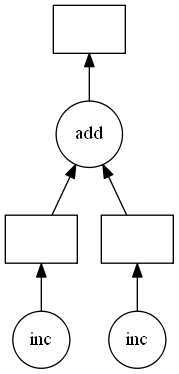

In [85]:
z.visualize()

begins by importing the packages needed for this example: in this
case, the delayed package and the ProgressBar diagnostic we used
previously. Next, we define a couple simple Python functions. The first adds
one to its given input, and the second adds the two given inputs. The next
three lines introduce the delayed _constructor_. By wrapping delayed around a
function, a Dask Delayed representation of the function is produced. Delayed
objects are equivalent to a node in a DAG. The arguments of the original
function are passed in a second set of parentheses. 

 At the bottom
of the graph, we can see the two calls to the inc function. That function
didn’t have any Delayed dependencies of its own, so there are no lines with
arrows pointing into the inc nodes. However, the add node has two lines with
arrows pointing into it. This represents the dependency on first calculating x
and y before being able to sum the two values. Since each inc node is free of
dependencies, a unique worker would be able to work on each taskindependently. Taking advantage of parallelism like this could be very
advantageous if the inc function took a long time to evaluate.

### **Visualizing More Complex DAGs With Loops And Collections**

In [87]:
def add_two(x):
    return x + 2

In [88]:
def sum_two_numbers(x,y):
    return x + y

In [89]:
def multiply_four(x):
    return x * 4

In [91]:
data = [1, 5, 8, 10]

In [92]:
step1 = [delayed(add_two)(i) for i in data]

In [93]:
total = delayed(sum)(step1)

In [94]:
total.compute()

32

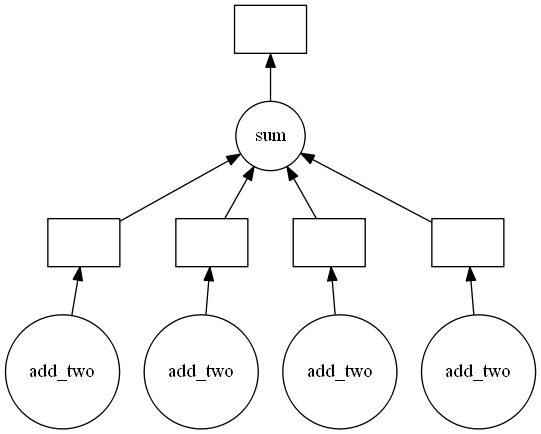

In [95]:
total.visualize()

This time, though, instead of creating a Delayed object from a
single function call, the Delayed constructor is placed inside a list
comprehension that iterates over the list of numbers. The result is that step1
becomes a list of Delayed objects instead of a list of integers.

In [96]:
step2 = [delayed(multiply_four)(j) for j in step1]

In [97]:
step2

[Delayed('multiply_four-28a07d23-c45c-4f56-a06d-d957ad36ed1e'),
 Delayed('multiply_four-d4fde8b5-7c17-45e1-9883-1dc3fda3c22c'),
 Delayed('multiply_four-398fca60-c34a-4a12-85aa-042a8a5064ab'),
 Delayed('multiply_four-cb90760c-d81a-4422-9eb3-839a71d96806')]

In [99]:
total = delayed(sum)(step2)

In [100]:
total.compute()

128

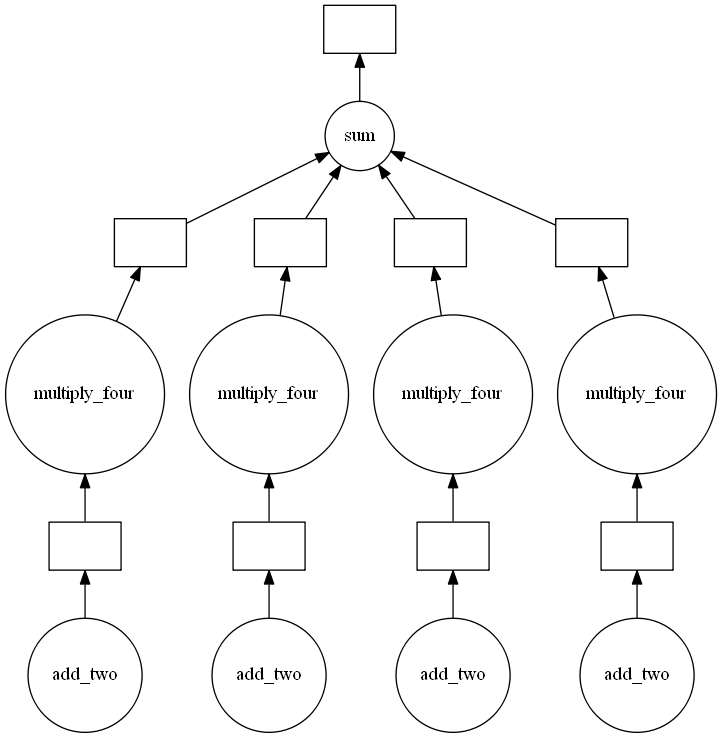

In [101]:
total.visualize()

### **Reducing DAG Complexity With Persist**

Let’s now take this one step further: say we want to take this sum, add it
back to each of our original numbers, then sum all that together.

In [104]:
data2 = [delayed(sum_two_numbers)(k, total) for k in data]

In [105]:
data2

[Delayed('sum_two_numbers-dd62c7d6-dc99-4011-aba2-a862cc2a86f2'),
 Delayed('sum_two_numbers-58af684d-abf9-4d4d-ab92-ce8cb3ecf865'),
 Delayed('sum_two_numbers-4767c452-de7d-489b-a9e0-a8fcda747b73'),
 Delayed('sum_two_numbers-57a180a4-6e35-4098-a697-6b22a797782c')]

In [107]:
total2 = delayed(sum)(data2)

In [108]:
total2.compute()

536

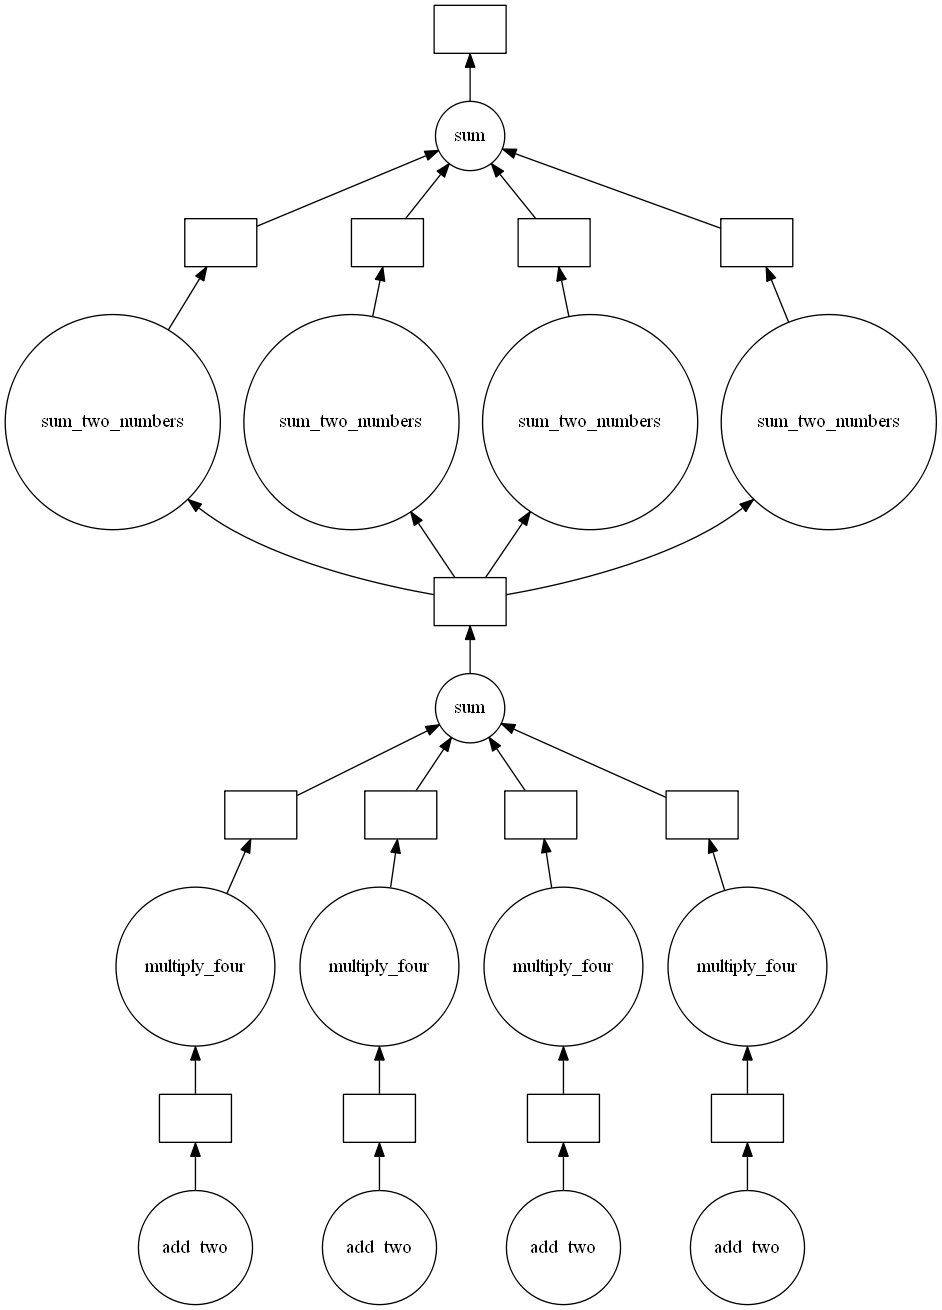

In [109]:
total2.visualize()

First,
Dask will calculate the sum of the first set of transformations, then add it to
each of the original numbers, then finally compute the sum of that
intermediate step. As you can imagine, if we repeat this cycle a few more
times, the DAG will start to get too large to visualize. Similarly, if we had 100
numbers in the original list instead of 4, the DAG diagram would also be very
large (try replacing the data list with a range[100] and rerun the code!) But
we touched on a more important reason in the last section as to why a large
DAG might become unwieldy: persistence.

As mentioned before, every time you call the compute method on a Delayed
object, Dask will step through the complete DAG to generate the result. This
can be okay for simple computations, but if you’re working on very large,
distributed datasets, it can quickly become inefficient to repeat calculations
over and over again. One way around that is to persist intermediate results
that you want to reuse. 

In [110]:
total_persisted = total.persist()

In [111]:
total_persisted

Delayed('sum-ead581a1-538e-459d-b055-3d1170ae9881')

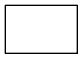

In [112]:
total_persisted.visualize()

we took the DAG we created before and persisted it.
What we get instead of the full DAG is a single result (remember that a rectangle represents a result). This result represents the
value that Dask would calculate when the compute method is called on the
total object. But instead of re-computing it every time we need to access its
value, Dask will now compute it once and save the result in memory. We can
now chain another delayed calculation on top of this persisted result, and we
get some interesting results

In [117]:
data3 = [delayed(sum_two_numbers)(k, total_persisted) for k in data]
total3 = delayed(sum)(data3)
total3.compute()

536

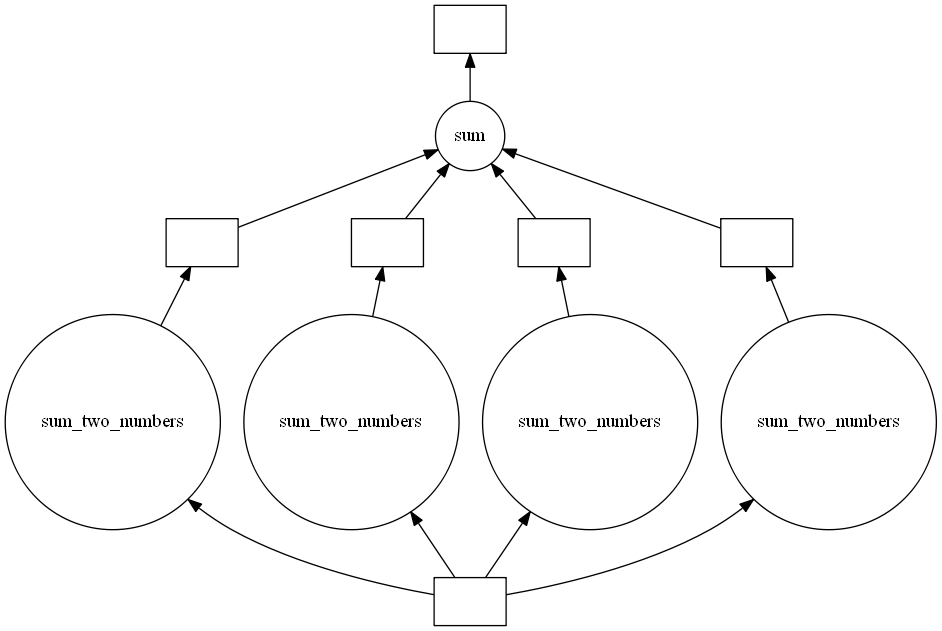

In [118]:
total3.visualize()

The resulting DAG is much smaller. In fact, it looks like only
the top half of the DAG before. That’s because the sum-#1 result is
precomputed and persisted. So instead of calculating the whole DAG, Dask can use the persisted data, thereby reducing the number of
calculations needed to produce the result.

Dask can
generate very large DAGs. Although the diagram won’t fit on this page, it will
hopefully give you an appreciation of the complexity that Dask can handle
very elegantly. Take a try!

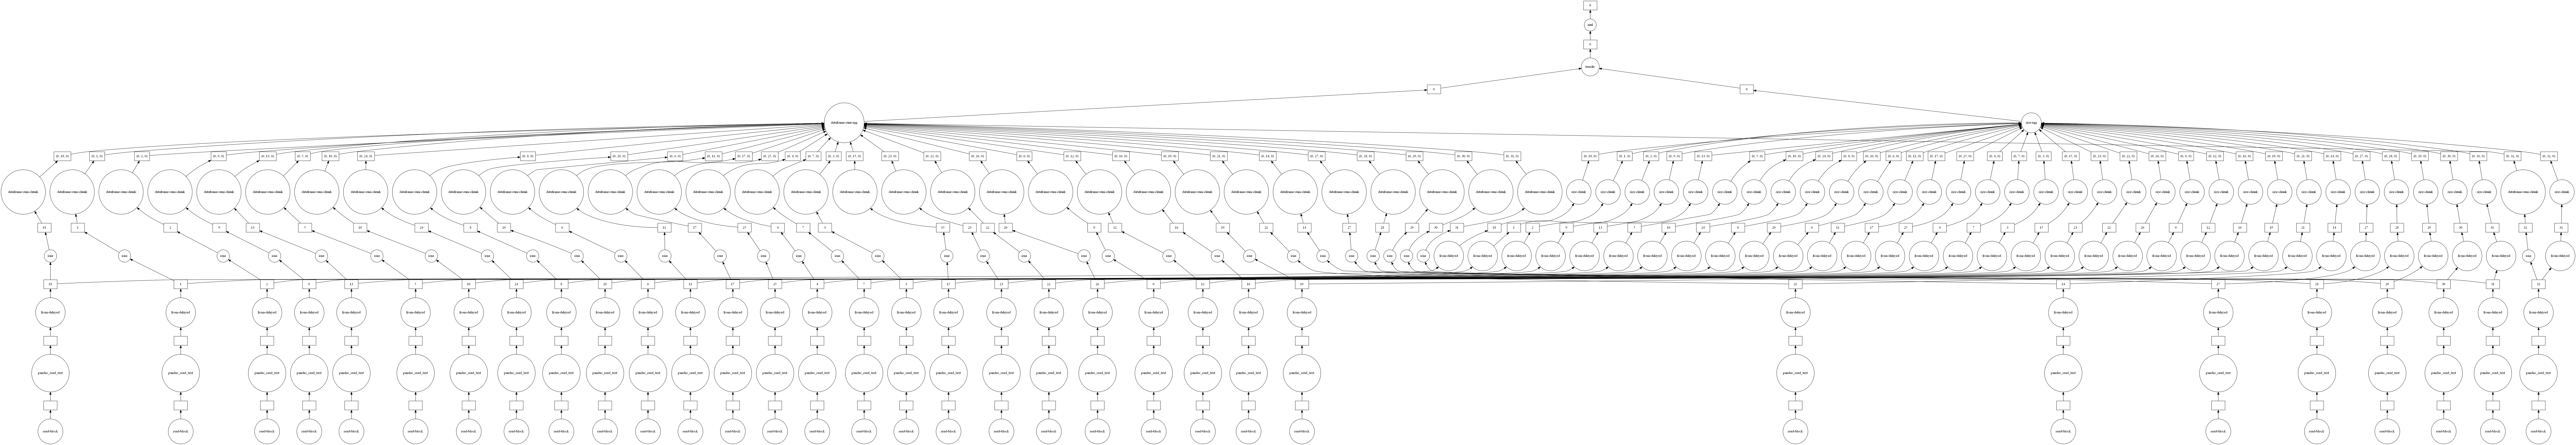

In [121]:
missing_percent.visualize()

## **Task Scheduling**

As I’ve mentioned a few times now, Dask uses the concept of lazy
computations throughout its API. We’ve seen the effect of this in action—
whenever we perform some kind of action on a Dask Delayed object, we have
to call the compute method before anything actually happens. This is quite
advantageous when you consider the time it might take to churn through
petabytes of data. Since no computation actually happens until you request
the result, you can define the complete string of transformations that Dask
should perform on the data without having to wait for one computation to
finish before defining the next—leaving you to do something else
while the complete result is computing

### **Lazy Computations**

Lazy computations also allow Dask to split work into smaller logical pieces,
which helps avoid loading the entire data structure that it’s operating on into
memory. As you saw with the DataFrame before, Dask divided the 2
GB file into 33 64 MB chunks, and operated on 8 chunks at a time. That
means the maximum memory consumption for the entire operation didn’t
exceed 512 MB, yet we were still able to process the entire 2 GB file. This gets
even more important as the size of the datasets you work on stretches into
the terabyte and petabyte range.

But what actually happens when you request the result from Dask? The
computations you defined are represented by a DAG, which is a step-by-step
plan for computing the result you want. However, that step-by-step plan
doesn’t define which physical resources should be used to perform the
computations. Two important things still must be considered: where the
computations will take place and where the results of each computation
should be shipped to if necessary. Unlike relational database systems, Dask
does not predetermine the precise runtime location of each task before the
work begins. Instead, the task scheduler dynamically assesses what work has
been completed, what work is left to do, and what resources are free to accept
additional work in real time. This allows Dask to gracefully handle a host of
issues that arise in distributed computing, including recovery from worker
failure, network unreliability, and workers completing work at different
speeds. In addition, the task scheduler can keep track of where intermediate
results have been stored, allowing follow-on work to be shipped to the datainstead of unnecessarily shipping the data around the network. This results
in far greater efficiency when operating Dask on a cluster.

### **Data Locality**

Since Dask makes it easy to scale up your code from your laptop to hundreds
or thousands of physical servers, the task scheduler must make intelligent
decisions about which physical machine(s) will be asked to take place in a
specific piece of a computation. Dask uses a centralized task scheduler to
orchestrate all this work. To do this, each Dask worker node reports what
data it has available and how much load it’s experiencing to the task
scheduler. The task scheduler constantly evaluates the state of the cluster to
come up with fair, efficient execution plans for computations submitted by
users. For example, if we split the example(reading the NYC
parking ticket data) between two computers (server A and server B), the task
scheduler may state that an operation on partition 26 should be performed
by server A, and the same operation should be performed on partition 8 by
server B. For the most part, if the task scheduler divides up the work as
evenly as possible across machines in the cluster, the computations will
complete as quickly and efficiently as possible.

But that rule of thumb does not always hold true in a number of scenarios:
one server is under heavier load than the others, has less powerful hardware
than the others, or does not have fast access to the data. If any of those
conditions is true, the busier/weaker server will lag behind the others, and
therefore should be given proportionately fewer tasks to avoid becoming a
bottleneck. The dynamic nature of the task scheduler allows it to react to
these situations accordingly if they cannot be avoided.

For best performance, a Dask cluster should use a distributed filesystem
like S3 or HDFS to back its data storage. To illustrate why this is important,
consider the following counterexample, where a file is stored on only one
machine. For the sake of our example, the data is stored on server A. When
server A is directed to work on partition 26, it can read the partition directly
off its hard disk. However, this poses a problem for server B. Before server B
can work on partition 8, server A will need to send partition 8 to server B.
Any additional partitions that server B is to work on will also need to be sent
over to server B before the work can begin. This will cause a considerable
slowdown in the computations because operations involving networking
(even 10 Gb fiber) are slower than direct reads off of locally attached disks.

The remedy to this problem would be to split the file up ahead of time,
store some partitions on server A, and store some partitions on server B. This
is precisely what a distributed file system does. Logical files are split upbetween physical machines. Aside from other obvious benefits, like
redundancy in the event one of the servers’ hard disks fails, distributing the
data across many physical machines allows the workload to be spread out
more evenly. It’s far faster to bring the computations to the data than to
bring the data to the computations!

Dask’s task scheduler takes data locality, or the physical location of data,
into account when considering where a computation should take place.
Although it’s sometimes not possible for Dask to completely avoid moving
data from one worker to another, such as instances where some data must be
broadcast to all machines in the cluster, the task scheduler tries its hardest to
minimize the amount of data that moves between physical servers. When
datasets are smaller, it might not make much difference, but when datasets
are very large, the effects of moving data around the network are much more
evident. Therefore, minimizing data movement generally leads to more
performant computations